In [1]:
import numpy as np
import torch
import torch.nn as nn
from torch.autograd import Variable
import skorch

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
import torchvision

In [4]:
def sg(x):
    """ stop gradinet function from the paper """
    return x.detach()
    return skorch.utils.to_var(x.data, use_cuda=x.is_cuda)

In [55]:
def l2(x, eps=1e-8, dim=None, keepdim=False):
    return ((x**2).sum(dim=dim, keepdim=keepdim) + eps).sqrt()

In [388]:
class MLPEncoder(nn.Module):
    def __init__(self, input_size, hidden_dim, latent_dim):
        super().__init__()
        self.l0 = nn.Conv2d(in_channels, out_channels, kernel_size, input_size, hidden_dim)
        self.l1 = nn.Linear(hidden_dim, hidden_dim)
        self.act = nn.ReLU()
        
        self.hidden_dim = hidden_dim
        self.latent_dim = latent_dim
        
        assert self.hidden_dim % self.latent_dim == 0

    def forward(self, x):
        l0 = self.l0(x)
        l0 = self.act(l0)
        l1 = self.l1(l0)
        l1 = self.act(l1)
        return l1.view(x.size(0), self.hidden_dim // self.latent_dim, self.latent_dim)

In [587]:
class CNNEncoder(nn.Module):
    def __init__(self, input_size, _hidden_dim, latent_dim):
        super().__init__()
        # l1 produces (b, latent_dim, 21, 21)
        self.l0 = nn.Conv2d(1, latent_dim, kernel_size=3) # 28-(3-1) = 26
        self.l1 = nn.Conv2d(latent_dim, latent_dim, kernel_size=9) # 26 - (9-1) = 18
        self.act = nn.ReLU()
        self.latent_dim = latent_dim
        
    def forward(self, x):
        x = x.view(-1, 1, 28, 28)
        l0 = self.l0(x)
        l0 = self.act(l0)
        l1 = self.l1(l0)
        l1 = self.act(l1)
        return l1.permute(0, 2, 3, 1).contiguous()

In [588]:
class MLPDecoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim, output_dim):
        super().__init__()
        self.l0 = nn.Linear(hidden_dim, hidden_dim)
        self.l1 = nn.Linear(hidden_dim, output_dim)
        self.act = nn.ReLU()

    def forward(self, x):
        l0 = self.l0(x.view(x.size(0), -1))
        l0 = self.act(l0)
        l1 = self.l1(l0)
        #return (l1)
        return torch.nn.functional.sigmoid(l1)

In [596]:
class CNNDecoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim, output_dim):
        super().__init__()
        self.l0 = nn.ConvTranspose2d(latent_dim, latent_dim, kernel_size=9)
        self.l1 = nn.ConvTranspose2d(latent_dim, 1, kernel_size=3)
        self.act = nn.ReLU()

    def forward(self, x):
        l0 = self.l0(x.permute(0, 3, 1, 2))
        l0 = self.act(l0)
        l1 = self.l1(l0)
        return torch.nn.functional.sigmoid(l1)

In [597]:
class Discretizer(nn.Module):
    def __init__(self, num_latents, emb_dim):
        super().__init__()
        self.num_latents = num_latents
        self.hidden_dim = emb_dim
        #self.e = nn.Parameter(torch.zeros((num_latents, hidden_dim)))
        self.e = nn.Parameter(torch.randn((num_latents, emb_dim)) * 0.02)

        self.count=1
        
        print(self.e.size())
        
    def distance(self, a, b):
        return l2(a - b, dim=-1)
    
    def forward(self, z_e):
        
        e_exp = self.e.view(1, 1, 1, self.num_latents, self.hidden_dim)
        z_exp = z_e.unsqueeze(3).repeat(1, 1, 1, self.num_latents, 1)
        
        d = self.distance(z_exp, e_exp)
        _min_dists, idx = d.min(-1)
        
        return self.e[idx.view(-1)].view(*z_e.size())
        return self.e[idx]
        
        
        #return z_e
        org_shape = z_e.size()
        #z_e = z_e.view(-1, z_e.size(-1))
        
        
        # compute min distance between z_e and self.e for each row in z_e,
        # return matrix with (_, e_{best match for each row})

        # to find the embedding row of self.e that matches best with the input
        # for each row in the input z_e, we first have to align both tensors.
        #z_e_exp = z_e.repeat(1, self.e.size(0)).view(z_e.size(0) * self.e.size(0), -1)
        #e_exp = self.e.repeat(z_e.size(0), 1)
        
        z_e_exp = z_e.repeat(self.e.size(0), 1)
        e_exp = self.e.repeat(z_e.size(0), 1)
        
        d = self.distance(z_e_exp, e_exp)
        d = d.view(z_e.size(0), self.e.size(0))

        _min_dists, idx = d.min(-1)
        #print(_min_dists)
        
        if self.count % 100 == 0:
            #import pdb; pdb.set_trace()
            pass
        self.count += 1
        
        #import pdb; pdb.set_trace()

        #return Variable(self.e[idx].view(org_shape).data, requires_grad=True)
        return self.e[idx].view(org_shape)

In [598]:
class VQVAE(nn.Module):
        def __init__(
            self, 
            input_dim, 
            hidden_dim, 
            num_latents, 
            latent_dim, 
            encoder=MLPEncoder,
            decoder=MLPDecoder,
        ):
            super().__init__()
            self.enc = encoder(input_dim, hidden_dim, latent_dim)
            self.dis = Discretizer(num_latents, latent_dim)
            self.dec = decoder(latent_dim, hidden_dim, input_dim)

        def forward(self, x):
            z_e = self.enc(x)
            e_k = self.dis(z_e)
            z_q = self.dec(e_k)
            #import pdb; pdb.set_trace()
            return z_q, z_e, e_k

In [599]:
MNIST = torchvision.datasets.MNIST('../data', train=True, download=True,
                   transform=torchvision.transforms.Compose([
                       torchvision.transforms.ToTensor(),
                       torchvision.transforms.Normalize((0.1307,), (0.3081,))
                   ]))

In [600]:
train_loader = lambda _ds, **kwargs: torch.utils.data.DataLoader(MNIST, **kwargs)

In [601]:
class Trainer(skorch.NeuralNet):
        def __init__(self, beta=0.25, criterion=nn.MSELoss, *args, **kwargs):
            self.beta = beta
            super().__init__(*args, criterion=criterion, **kwargs)
            
        def initialize_module(self, *args, **kwargs):
            r = super().initialize_module(*args, **kwargs)
            
#             self.module_.enc.l0.weight.register_hook(lambda grad: print('l0grad',grad.mean()))
#             self.module_.enc.l1.weight.register_hook(lambda grad: print('l1grad',grad.mean()))
            
            return r
            
        def evaluation_step(self, *args, **kwargs):
            ret = super().evaluation_step(*args, **kwargs)
            return ret[0]

        def train_step(self, X, _, _opt):
            self.optimizer_.zero_grad()
            
            X = X.view(-1, 28 * 28)
            X = skorch.utils.to_var(X, use_cuda=self.use_cuda)
            y = skorch.utils.to_var(X, use_cuda=self.use_cuda)
            
            z_q, z_e, e_k = self.infer(X)

            recon = self.criterion_(z_q, y)
            vq = l2(sg(z_e) - e_k)
            commit = self.beta * l2(z_e - sg(e_k))
            
            #import pdb; pdb.set_trace()

            e_k.retain_grad()
            recon.backward(retain_graph=True)
            encode_grad = e_k.grad.clone()
            self.optimizer_.zero_grad()
            
            L = recon + vq + commit
            L.backward(retain_graph=True)
            
            z_e.backward(gradient=encode_grad)
            
            avg_encoder_grad = np.array([p.grad.mean().data[0] for p in self.module_.enc.parameters()]).mean()

            self.history.record_batch('recon', recon.data[0])
            self.history.record_batch('vq', vq.data[0])
            self.history.record_batch('commit', commit.data[0])
            self.history.record_batch('avg_enc_grad', avg_encoder_grad)
            self.history.record_batch('z_e', z_e.mean().data[0])

            self.optimizer_.step()
            
            return L

In [602]:
torch.manual_seed(42)
ef = Trainer(
    module=VQVAE,
    module__input_dim=28 * 28,
    module__hidden_dim=128,
    module__latent_dim=1,
    module__num_latents=128,
    module__encoder=CNNEncoder,
    module__decoder=CNNDecoder,
    
    beta=0.15,
    
    optimizer=torch.optim.Adam,
    optimizer__lr=0.002,

    iterator_train=train_loader,
    iterator_train__batch_size=64,
    iterator_train__shuffle=True,
    
    max_epochs=10,
    
    train_split=None,
    
    use_cuda=False,
    
    callbacks=[skorch.callbacks.ProgressBar(postfix_keys=[
        'train_loss', 'recon', 'vq','commit', 'avg_enc_grad', 'z_e'])],
).initialize()

torch.Size([128, 1])


In [603]:
%pdb on
if False:
    ef.load_params('vqvae.pt')
else:
    ef.fit(np.zeros(1), np.zeros(1))

Automatic pdb calling has been turned ON
Re-initializing module!
torch.Size([128, 1])


Widget Javascript not detected.  It may not be installed or enabled properly.


  epoch    train_loss       dur
-------  ------------  --------
      1        1.0826  198.1633


Widget Javascript not detected.  It may not be installed or enabled properly.


In [604]:
ef.save_params('vqvae.pt')

### Evaluation

In [605]:
num_samples = 10
grid_side = np.ceil(np.sqrt(num_samples))
X_eval = np.array([x.view(28 * 28) for _, (x,y) in zip(range(num_samples), iter(MNIST))])
X_eval_hat = ef.predict_proba(X_eval)

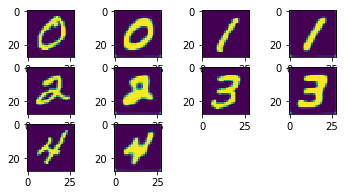

In [606]:
for i in range(1, num_samples, 2):
    plt.subplot(grid_side, grid_side, i)
    plt.imshow(X_eval[i].numpy().reshape(28, 28))
    plt.subplot(grid_side, grid_side, i+1)
    plt.imshow(X_eval_hat[i].reshape(28, 28))

In [607]:
z_q, z_e, e_k = ef.infer(torch.stack(X_eval, dim=0))

In [608]:
z_e.size()

torch.Size([10, 18, 18, 1])

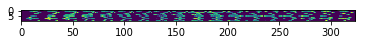

In [609]:
plt.imshow(z_e.view(num_samples, -1).data.cpu().numpy())

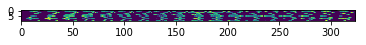

In [610]:
plt.imshow(e_k.view(num_samples, -1).cpu().data.numpy())

### Discrete embedding vectors

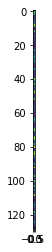

In [611]:
plt.imshow(ef.module_.dis.e.data.cpu().numpy())

### Distance between latent vectors

In [612]:
D = np.array([[ef.module_.dis.distance(a,b).data[0] for a in ef.module_.dis.e] 
              for b in ef.module_.dis.e])

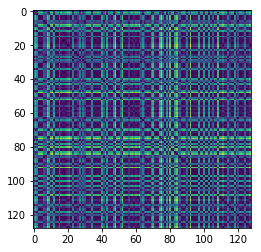

In [613]:
plt.imshow(D)